# English-to-Spanish translation with a sequence-to-sequence Transformer
_Felipe Andres Castillo_

**Original author:** [fchollet](https://twitter.com/fchollet)<br>
**Description:** Implementing a sequence-to-sequence Transformer and training it on a machine translation task. The code featured here is adapted from the book
[Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)
(chapter 11: Deep learning for text).

## Setup

In [41]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib          # Manejo de rutas de archivos
import random           # Generación de números aleatorios
import string           # Utilidades para manejar cadenas de texto
import re               # Expresiones regulares
import numpy as np      # Numpy para operaciones numéricas
import seaborn as sns   # Para gráficar heatmaps
import matplotlib.pyplot as plt

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
import keras.ops as ops   # Proporciona operaciones matemáticas
from keras import layers  # Capas predefinidas de Keras
from keras.layers import TextVectorization  # Capa clave para procesar texto antes de alimentar los datos al modelo

## Downloading the data

Se descarga el dataset que contiene las frases en inglés y español, obtenido de [Anki](https://www.manythings.org/anki/).

In [43]:
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng_extracted" / "spa-eng" / "spa.txt"

## Parsing the data

Se lee el archivo de texto, procesa cada línea y genera pares de oraciones en inglés (source sequence) y español (target sequence), agregando los tokens especiales "[start]" y "[end]" a las oraciones en español.

In [44]:
with open(text_file) as f:
  # Lee el contenido y lo divide en líneas usando el carácter de nueva línea \n
  # [:-1] elimina la última línea si está vacía (para evitar errores en el procesamiento)
  lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
  # Cada línea tiene una oración en inglés y su traducción en español, separadas por un tabulador (\t).
  # Se agregan los tokens especiales [start] y [end] a la oración en español.
  # Esto es útil para que el modelo aprenda a detectar el inicio y final de la secuencia de traducción.
  eng, spa = line.split("\t")
  spa = "[start] " + spa + " [end]"
  text_pairs.append((eng, spa))

In [45]:
# Ejemplos de los pares de oraciones inglés-español
for _ in range(5):
    print(random.choice(text_pairs))

('I want to talk to you about Tom.', '[start] Quiero hablar con vosotros sobre Tom. [end]')
('I know that it is highly unlikely that anyone would be willing to help me.', '[start] Sé que es muy poco probable que alguien esté dispuesto a ayudarme. [end]')
('Are you happy with your weight?', '[start] ¿Estás conforme con tu peso? [end]')
('The apple fell from the tree.', '[start] La manzana cayó del árbol. [end]')
('The paper is white.', '[start] El papel es blanco. [end]')


Se dividen los datos en conjuntos de entrenamiento, validación y prueba de manera aleatoria.

In [46]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


## Vectorizing the text data

Se configuran dos funciones para vectorizar el texto (TextVectorization), una para inglés y otra para español.

Se normaliza el texto, es decir, se eliminan los signos de puntuación y otros caracteres especiales. Se definen las caracteristicas del vocabulario que se han de tomar en cuenta cuando se vectorizen las palabras.

In [50]:
# string.punctuation contiene signos de puntuación estándar como .,!?;: y se agrega manualmente "¿"
# Entre los caracteres especial no se consideran [ y ] porque en el dataset se utilizan en los tokens [start] y [end]
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000    # Tamaño del vocabulario (número máximo de palabras únicas)
sequence_length = 20  # Longitud máxima de las secuencias de entrada
batch_size = 64       # Tamaño del batch para entrenamiento

# Esta función convierte el texto a minúsculas y elimina caracteres no deseados (definidos en strip_chars)
def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


# TextVectorization para las frases en inglés
eng_vectorization = TextVectorization(
    max_tokens = vocab_size,                  # Usa solo las 15,000 palabras más frecuentes.
    output_mode = "int",                      # Convierte el texto en secuencias de índices enteros
    output_sequence_length = sequence_length, # Cada secuencia tendrá un tamaño fijo
)
# TextVectorization para las frases en español
spa_vectorization = TextVectorization(
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length + 1, # +1 porque la salida tiene un token extra ([start])
    standardize = custom_standardization,
)

train_eng_texts = [pair[0] for pair in train_pairs] # Extrae oraciones en inglés
train_spa_texts = [pair[1] for pair in train_pairs] # Extrae oraciones en español

# adapt() analiza las frases, y construye un vocabulario, asignando índices a las palabras más frecuentes
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

Lo siguiente es formatear los datasets.

En cada paso del entrenamiento, el modelo buscará predecir la palabra N+1 utilizando la oración en inglés (source sentence) y las N palabras objetivo (target words).

El conjunto de datos de entrenamiento producirá una tupla `(inputs, targets)`, donde:
- `inputs` es un diccionario con las claves `encoder_inputs` y `decoder_inputs`
- `encoder_inputs` es la oración en inglés vectorizada, mientras que `decoder_inputs` es la oración objetivo que se tiene hasta el momento (0 a N palabras) que es utilizada para predecir la palabra N+1 (y las consecuentes palabras) de la oración en español.
- `target` es la oración objetivo desplzada un paso; es decir, proporciona las siguientes palabras que el modelo intentará predecir.

In [51]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng) # Convierte la oración en inglés en secuencia de enteros, es decir, es vectorizada
    spa = spa_vectorization(spa) # Se vectoriza la oración en español
    # Se retorna un diccionario con entradas para el modelo
    return (
        {
            "encoder_inputs": eng,          # Secuencia en inglés para el encoder
            "decoder_inputs": spa[:, :-1],  # Secuencia en español sin el último token
        },
        spa[:, 1:], # Este es el segundo elemento de la tupla (target): secuencia en español sin el primer token (desplazada un paso a la derecha)
    )


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)  # Separa las oraciones en inglés y español
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))  # Crea un dataset de TensorFlow
    dataset = dataset.batch(batch_size)                                   # Agrupa en batches
    dataset = dataset.map(format_dataset)                                 # Aplica format_dataset() a cada batch para vectorizarlo
    # Optimización del dataset:
    # .cache(): Almacena en caché para evitar recalcular en cada época
    # .shuffle(2048): Mezcla los datos con un buffer de 2048 elementos
    # .prefetch(16): Mejora el rendimiento cargando hasta 16 batches en memoria anticipadamente
    return dataset.cache().shuffle(2048).prefetch(16)

# Creación de datasets de entrenamiento y validación
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Si se toma un batch de datos de train_ds, podemos revisar las dimensiones de sus tensores para verificar que los datos están correctamente formateados.
- 64 → Tamaño del batch (64 frases por batch).
- 20 → Longitud máxima de cada oración (cortadas o rellenadas con padding).

In [52]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


## Building the model

El sequence-to-sequence Transformer consiste en un `TransformerEncoder` y en un
`TransformerDecoder` encadenados. Para que el modelo reconozca el orden de las palabras se utiliza una `PositionalEmbedding` layer.

La secuencia en inglés (source sequence) pasa al `TransformerEncoder`, el cual producirá una nueva representación de ella. Esta nueva representación pasará al `TransformerDecoder`, junto con la secuencia en español (target sequence) que se tiene hasta el momento. El `TransformerDecoder`intentará predecir las siguientes palabras de la secuencia objetivo.

El detalle clave que hace posible esto es el "enmascaramiento" (`get_causal_attention_mask()` en el `TransformerDecoder`).
El `TransformerDecoder` ve todas las secuencias a la vez, por lo que se debe garantizar que solo use la información proveniente de los 0 a N tokens objetivo para predecir el token N+1 (de lo contrario, podría utilizar información del futuro, lo que resultaría en un modelo inutilizable en la inferencia).

### Encoder

In [53]:
# La capa Encoder se encarga de procesar las oraciones en inglés antes de pasarlas al Decoder
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        # Capa Multi-Head Attention: aprende relaciones entre palabras en la oración
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        # Capa feedforward: para mejorar la representación
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        # Normalización: ayuda a estabilizar el entrenamiento y mejorar la convergencia
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        # Enmascarar para evitar que afecte la atención
        self.supports_masking = True

    # Esta función recibe un batch de embeddings de palabras
    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None
        # SE CAPTURA LA SALIDA Y PESOS DEL ATTENTION LAYER
        attention_output, attention_weights = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask, return_attention_scores=True
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        encoder_output = self.layernorm_2(proj_input + proj_output)
        return encoder_output, attention_weights

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

### Positional Embedding

In [56]:
# EL PositionalEmbedding ayuda al Transformer a entender el orden de las palabras,
# ya que, a diferencia de los modelos recurrentes, no procesa palabras en secuencia
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        # Convierte cada token en un vector de dimensión embed_dim
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        # Aprende un embedding para cada posición de la secuencia
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    # Los inputs son la secuencia de tokens
    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs) # convierte tokens en vectores
        embedded_positions = self.position_embeddings(positions) # asigna un vector a cada posición
        # La suma permite que el Transformer capture tanto el significado de cada palabra
        # como su posición en el contexto, sin necesidad de procesar la secuencia de manera recurrente
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

### Decoder

In [55]:
# El Decoder procesa la entrada del decodificador (inputs) y la salida del encoder (encoder_outputs)
# usando mecanismos de atención para generar la salida traducida
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        # Self-Attention en el decodificador
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        # Cross-Attention con el encoder
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        inputs, encoder_outputs = inputs
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is None:
            inputs_padding_mask, encoder_outputs_padding_mask = None, None
        else:
            inputs_padding_mask, encoder_outputs_padding_mask = mask
        # Relaciona cada token con los tokens previos
        attention_output_1, attn_weights_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
            query_mask=inputs_padding_mask,
            return_attention_scores=True  # SE DEVUELVEN LOS PESOS
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)
        # Relaciona la representación del decodificador con la salida del encoder para obtener información sobre el contexto
        attention_output_2, attn_weights_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            query_mask=inputs_padding_mask,
            key_mask=encoder_outputs_padding_mask,
            return_attention_scores=True  # SE DEVUELVEN LOS PESOS
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)
        # Transformación no lineal para refinar la representación
        proj_output = self.dense_proj(out_2)
        decoder_output = self.layernorm_3(out_2 + proj_output)
        return decoder_output, attn_weights_1, attn_weights_2

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

### Ensamble del modelo

In [58]:
embed_dim = 300 #256
latent_dim = 2048
num_heads = 8


# 1. Se define una entrada de secuencia encoder_inputs (tamaño arbitrario None)
# 2. Se aplica PositionalEmbedding para obtener representaciones enriquecidas con información posicional
# 3. Se pasa la salida por el TransformerEncoder, que aplica self-attention y feedforward
# 4. Se crea el modelo del Encoder
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs, encoder_attn_weights = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, [encoder_outputs, encoder_attn_weights])

# 1. Se definen dos entradas: para la secuencia de palabras en español y para la representación latente generada por el encoder
# 2. Se aplica PositionalEmbedding a la entrada del decoder
# 3. Se pasa esta entrada al TransformerDecoder, junto con la salida del encoder
# 4. Se aplica dropout
# 5. Se pasa por una capa densa con softmax, que genera la distribución de probabilidad sobre el vocabulario
# 6. Se crea el modelo del Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
decoder_outputs, decoder_attn_weights, cross_attn_weights = TransformerDecoder(embed_dim, latent_dim, num_heads)([x, encoder_outputs])
x = layers.Dropout(0.5)(decoder_outputs)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs],
                      [decoder_outputs, decoder_attn_weights, cross_attn_weights])

# Se combinan el encoder y el decoder en un solo modelo transformer,
# con entradas {encoder_inputs, decoder_inputs} y [salida decoder_outputs, encoder_attn_weights, decoder_attn_weights, cross_attn_weights]
transformer = keras.Model(
    {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
    [decoder_outputs, decoder_attn_weights, cross_attn_weights],
    name="transformer",
)

### Embeddings preentrenados de GloVe

Lo siguiente es descargar y utiliza embeddings preentrenados de GloVe (Global Vectors for Word Representation) para inicializar una matriz de embeddings en el modelo.

In [57]:
#  Se descargan y extraen los embeddings de GloVe
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

# Se cargan los embeddings en un diccionario
# De entre los archivos extraidos, se escoge el de 300 dimensiones
embedding_dim = 300
embeddings_index = {}
with open("glove.6B.300d.txt", encoding="utf-8") as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs # embeddings_index es un diccionario que mapea palabras a vectores de 300 dimensiones

# Se crea la matriz de embeddings para el vocabulario de inglés
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for i, word in enumerate(eng_vectorization.get_vocabulary()):
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

--2025-03-23 04:50:47--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  1.99MB/s    in 9m 53s  

2025-03-23 05:00:50 (1.39 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [61]:
# Asignar los embeddings preentrenados de GloVe a la capa de embeddings del encoder
embedding_layer = transformer.get_layer("positional_embedding_2").token_embeddings
embedding_layer.set_weights([embedding_matrix])
embedding_layer.trainable = False

## Training the model

In [62]:
epochs = 30  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop",
    loss=[keras.losses.SparseCategoricalCrossentropy(ignore_class=0), None, None],
    #loss_weights=[1.0, 0.0, 0.0],
    metrics=[["accuracy"], None, None],
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_2    │ (None, None, 300)      │      4,506,000 │ encoder_inputs[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, None)           │              0 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_3    │ (None, None, 300)      │      4,506,000 │ decoder_inputs[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_1     │ [(None, None, 300),    │      4,119,848 │ positional_embedding_… │
│ (TransformerEncoder)      │ (None, 8, None, None)] │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, None)           │              0 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder_1     │ [(None, None, 300),    │      7,007,948 │ positional_embedding_… │
│ (TransformerDecoder)      │ (None, 8, None, None), │                │ transformer_encoder_1… │
│                           │ (None, 8, None, None)] │                │ not_equal_3[0][0],     │
│                           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, None, 300)      │              0 │ transformer_decoder_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, None, 15000)    │      4,515,000 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,654,796 (94.05 MB)

 Trainable params: 20,154,796 (76.88 MB)

 Non-trainable params: 4,500,000 (17.17 MB)

1302/1302 ━━━━━━━━━━━━━━━━━━━━ 127s 85ms/step - dense_9_accuracy: 0.1053 - loss: 4.9821 - val_dense_9_accuracy: 0.1933 - val_loss: 2.7849


In [ ]:
# Se guarda el modelo
from google.colab import drive
drive.mount('/content/drive')

transformer.save("/content/drive/My Drive/NMT_transformer.keras")

## Decoding test sentences

Finalmente es turno de traducir nuevas oraciones en inglés; para ello se define la función `decode_sequence`, la cual devuelve la oración traducida, además del conjunto de matrices de pesos.

In [27]:
# Se obtiene el vocabulario del español
spa_vocab = spa_vectorization.get_vocabulary()
# Se crea un diccionario para mapear los índices a las palabras en español
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

# eng_vocab = eng_vectorization.get_vocabulary()
# eng_index_lookup = dict(zip(range(len(eng_vocab)), eng_vocab))

In [28]:
def decode_sequence(input_sentence):
  # Se tokeniza la oración en inglés
  tokenized_input_sentence = eng_vectorization([input_sentence])
  # Se inicializa la oración traducida como "[start]"
  decoded_sentence = "[start]"

  # Se guardan los pesos
  # Se genera una matriz por palabra, pero sólo nos ineteresa la última, cuando la traducción está completa
  cross_attention_matrices = []

  # Se genera la traducción palabra por palabra
  for i in range(max_decoded_sentence_length):
    # Se tokeniza la oración parcial en español
    tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
    # Se obtiene la predicción del modelo
    predictions, _, cross_attn_weights = transformer(
        {
          "encoder_inputs": tokenized_input_sentence,
          "decoder_inputs": tokenized_target_sentence,
        }
      )
    # Se guardan los pesos
    cross_attention_matrices.append(cross_attn_weights[0])
    # Se selecciona el índice con la mayor probabilidad, y se convierte en una palabra en español
    sampled_token_index = ops.convert_to_numpy(ops.argmax(predictions[0, i, :])).item(0)
    sampled_token = spa_index_lookup[sampled_token_index]
    # Se agrega la nueva palabra
    decoded_sentence += " " + sampled_token
    if sampled_token == "[end]":
      break
  # el número de matrices en cross_attention_matrices[-1] será igual al número de heads
  return decoded_sentence, cross_attention_matrices[-1]

In [30]:
test_eng_texts = [pair[0] for pair in test_pairs]
for i in range(10):
    input_sentence = random.choice(test_eng_texts)
    translated, _ = decode_sequence(input_sentence)
    print(i, "Input:", input_sentence)
    print("Traducción:", translated.replace("[start]", "").replace("[end]", ""))

0 Input: I'm great at advice.
Traducción:  estoy muy bien 
1 Input: Tom tried to comfort Mary.
Traducción:  tom trató de [UNK] a mary 
2 Input: Tom doesn't like me.
Traducción:  a tom no me gusta 
3 Input: I can't understand that word.
Traducción:  no puedo entender esa palabra 
4 Input: Everyone stood.
Traducción:  todos los [UNK] 
5 Input: Tom and his friends went to the circus.
Traducción:  tom y sus amigos se fue a los amigos 
6 Input: Tom is now a happy little boy.
Traducción:  tom está ahora un poco feliz 
7 Input: Working alone is no fun.
Traducción:  a la [UNK] no es divertido 
8 Input: Today I love the entire world.
Traducción:  hoy me encanta la última vez 
9 Input: What kind of ice cream do you like?
Traducción:  qué tipo de acuerdo contigo 


In [38]:
input_sentence = random.choice(test_eng_texts)
translated_sentence, attn_weights = decode_sequence(input_sentence)

print("Input:", input_sentence)
print("Traducción:", translated_sentence.replace("[start]", "").replace("[end]", ""))
#print("Número de matrices de atención guardadas:", len(attn_weights))

Input: This letter contains sensitive information that may offend some people.
Traducción:  esta carta [UNK] de la [UNK] que puede [UNK] a las personas 


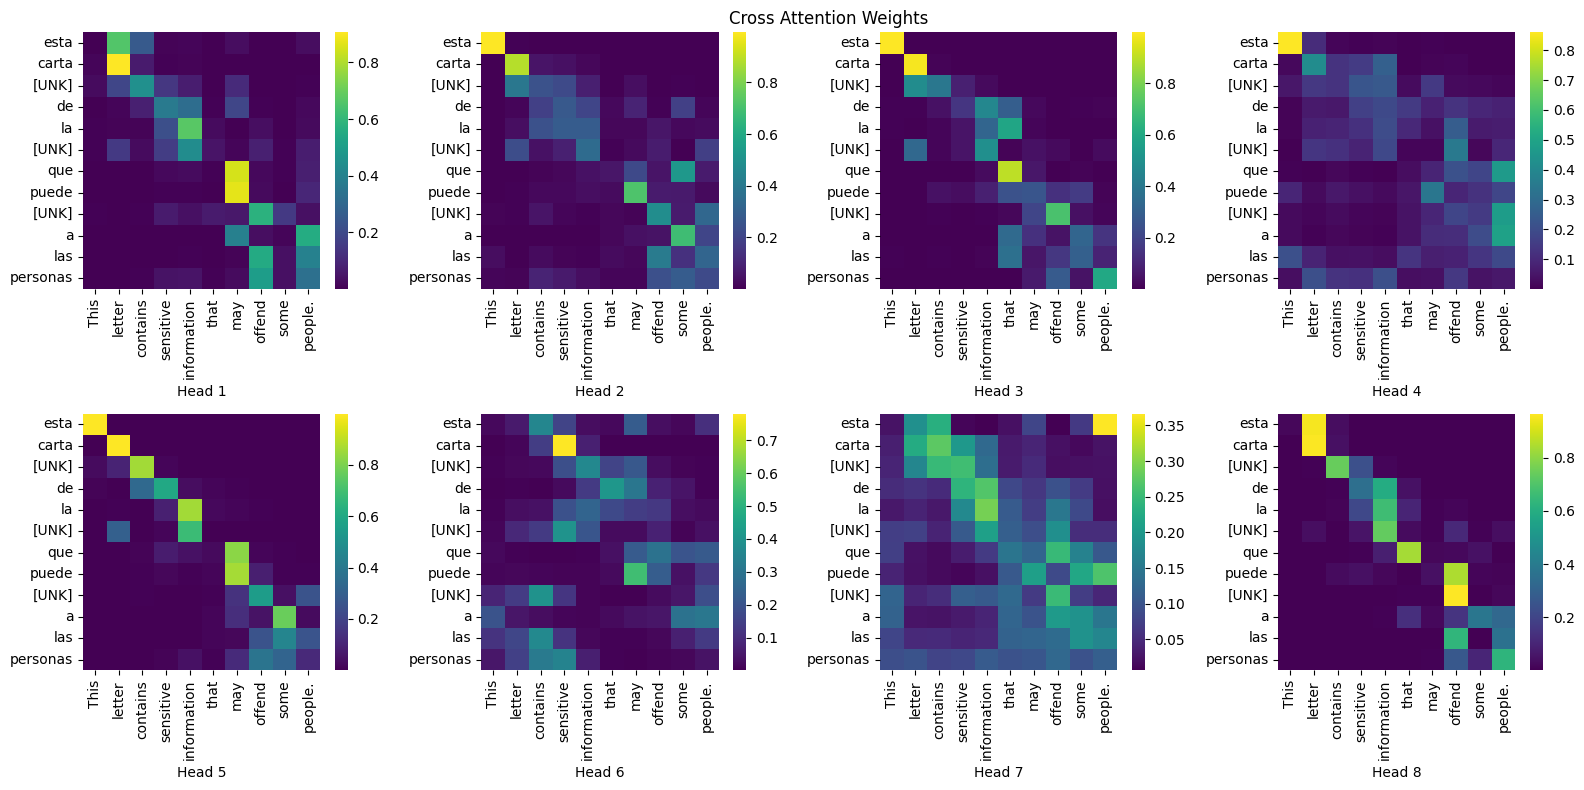

In [39]:
translated_tokens = translated_sentence.replace("[start]", "").replace("[end]", "").split()
input_tokens = input_sentence.split()

fig = plt.figure(figsize=(16, 8))
plt.title("Cross Attention Weights")
plt.axis('off')

for h, attn_matrix in enumerate(attn_weights):
  attn_matrix = attn_matrix[:len(translated_tokens), :len(input_tokens)]
  ax = fig.add_subplot(2, 4, h+1)
  sns.heatmap(attn_matrix, xticklabels=input_tokens, yticklabels=translated_tokens, cmap="viridis", annot=False, fmt=".2f", ax=ax, cbar=True)
  ax.set_xlabel(f'Head {h+1}')

plt.tight_layout()
plt.show()